# Accelerated Proximal Point Method (APPM) Example

This code tests the Accelerated Proximal Point Method which is the exact optimal method that 
reduces the fixed-point residual $||x - J_{\alpha A}x||$ with respect to the initial distance to the solution 
for a maximal monotone operator A. It was introduced in "Accelerated proximal point method for 
maximally monotone operators" by Donghwan Kim (2021). This method is equivalent to what 
later came to be known as the Optimized Halpern Method, which was studied in "On the 
Convergence Rate of the Halpern Iteration" by Felix Lieder (2021). The details of the 
equivalence can be found in Exercise 12.10 of Large-Scale Convex Optimization: 
Algorithms & Analyses via Monotone Operators by Ernest K. Ryu and Wotao Yin (2022).

## Import the required libraries

In [1]:
import pepflow as pf
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import display

## Define the operators

In [2]:
A = pf.MonotoneOperator(is_basis=True, tags=["A"])

## Write a function to return the PEPContext associated with APPM

In [3]:
def make_ctx_appm(
    ctx_name: str, N: int | sp.Integer, stepsize: pf.Parameter
) -> pf.PEPContext:
    ctx_appm = pf.PEPContext(ctx_name).set_as_current()
    x = pf.Vector(is_basis=True, tags=["x_0"])
    y = x.add_tag("y_0")
    A.set_zero_point("x_star")
    for i in range(N):
        x = A.resolvent(y, stepsize, tag=f"x_{i + 1}")
        y = (
            sp.S(i + 1) / sp.S(i + 2) * (sp.S(2) * x - y)
            + sp.S(1) / sp.S(i + 2) * ctx_appm["x_0"]
        ).add_tag(f"y_{i + 1}")

    return ctx_appm

## Numerical evidence of convergence of APPM

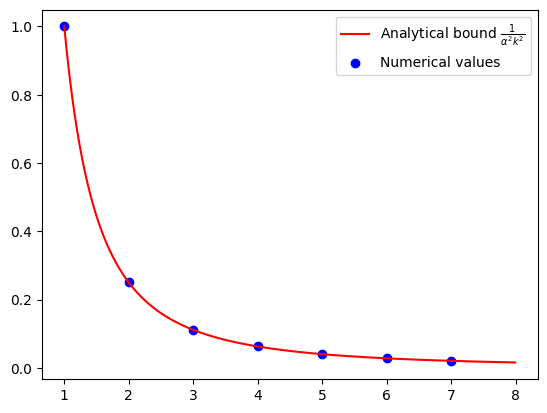

In [ ]:
N = 8
alpha = pf.Parameter("alpha")
R = pf.Parameter("R")
alpha_value = 1
R_value = 1

ctx_plt = make_ctx_appm(ctx_name="ctx_plt", N=N, stepsize=alpha)
pb_plt = pf.PEPBuilder(ctx_plt)
pb_plt.add_initial_constraint(
    ((ctx_plt["x_0"] - ctx_plt["x_star"]) ** 2).le(R, name="initial_condition")
)

opt_values = []
for k in range(1, N + 1):
    x_k = ctx_plt[f"x_{k}"]
    pb_plt.set_performance_metric(A(x_k) ** 2)
    result = pb_plt.solve(resolve_parameters={"alpha": alpha_value, "R": R_value})
    opt_values.append(result.opt_value)

iters = np.arange(1, N + 1)
cont_iters = np.arange(1, N, 0.01)
plt.plot(
    cont_iters,
    1 / (alpha_value**2 * cont_iters**2),
    "r-",
    label="Analytical bound $\\frac{1}{\\alpha^2 k^2}$",
)
plt.scatter(iters, opt_values, color="blue", marker="o", label="Numerical values")
plt.legend()

## Verification of convergence of APPM

In [5]:
N = sp.S(4)
alpha_value = sp.S(1)
R_value = sp.S(1)

ctx_prf = make_ctx_appm(ctx_name="ctx_prf", N=N, stepsize=alpha)
pb_prf = pf.PEPBuilder(ctx_prf)
pb_prf.add_initial_constraint(
    ((ctx_prf["x_0"] - ctx_prf["x_star"]) ** 2).le(R, name="initial_condition")
)
pb_prf.set_performance_metric(A(ctx_prf[f"x_{N}"]) ** 2)

result = pb_prf.solve(resolve_parameters={"alpha": alpha_value, "R": R_value})
print(result.opt_value)

# Dual variables associated with the interpolations conditions of f with no relaxation
lamb_dense = result.get_scalar_constraint_dual_value_in_numpy(A)

0.06250301959937275


In [6]:
pf.launch_primal_interactive(
    pb_prf, ctx_prf, resolve_parameters={"alpha": alpha_value, "R": R_value}
)

Dash app running on http://127.0.0.1:8050/


- It turns out for APPM no further relaxation is needed. Now we store the results.


In [7]:
# Dual variable associated with the initial condition
tau_sol = result.dual_var_manager.dual_value("initial_condition")
# Dual variable associated with the interpolations conditions of A
lamb_sol = result.get_scalar_constraint_dual_value_in_numpy(A)
# Dual variable associated with the Gram matrix G
S_sol = result.get_gram_dual_matrix()

### Verify closed form expression of $\lambda$

In [8]:
def tag_to_index(tag, N=N):
    """This is a function that takes in a tag of an iterate and returns its index.
    We index "x_star" as "N+1 where N is the last iterate.
    """
    # Split the string on "_" and get the index
    if (idx := tag.split("_")[1]).isdigit():
        return int(idx)
    elif idx == "star":
        return N + 1

- Print the values of $\lambda$ obtained from the solver

In [9]:
lamb_sol.pprint()

<IPython.core.display.Math object>

- Consider proper candidate of closed form expression of $\lambda$

In [10]:
def lamb(tag_i, tag_j, N=N):
    i = tag_to_index(tag_i)
    j = tag_to_index(tag_j)
    if j - 1 == i:
        if j == N + 1:
            return sp.S(2) / N  ## Between N and optimal
        else:
            return sp.S(2) * (sp.S(j) - sp.S(1)) * sp.S(j) / N**2  ## Consecutive
    return 0


lamb_cand = pf.pprint_labeled_matrix(
    lamb, lamb_sol.row_names, lamb_sol.col_names, return_matrix=True
)

<IPython.core.display.Math object>

- Check whether our candidate of $\lambda$ matches with solution

In [11]:
print(
    "Did we guess the right closed form of lambda?",
    np.allclose(lamb_cand, lamb_sol.matrix, atol=1e-3),
)

Did we guess the right closed form of lambda? True


### Closed form expression of $S$

In [12]:
S_sol.pprint()

<IPython.core.display.Math object>

In [13]:
ctx_prf.basis_vectors()

[y_0, x_star, A(x_1), A(x_2), A(x_3), A(x_4)]

In [14]:
x_0 = ctx_prf["x_0"]
x_N = ctx_prf[f"x_{N}"]
x_star = ctx_prf["x_star"]

S_guess = (A(x_N) - 1 / (alpha * N) * (x_0 - x_star)) ** 2

pm = pf.ExpressionManager(ctx_prf, resolve_parameters={"alpha": sp.S(1)})
S_guess_eval = pm.eval_scalar(S_guess).matrix
pf.pprint_labeled_matrix(S_guess_eval, S_sol.row_names, S_sol.col_names)

<IPython.core.display.Math object>

In [15]:
print(
    "Did we guess the right closed form of S?",
    np.allclose(S_guess_eval, S_sol.matrix, atol=1e-3),
)

Did we guess the right closed form of S? True


#### Verify symbolic calculation for fixed $N$

In [16]:
interpolation_scalar_sum = 0
for i in range(N + 2):
    for j in range(N + 2):
        xi = "x_star" if i == N + 1 else f"x_{i}"
        xj = "x_star" if j == N + 1 else f"x_{j}"
        if lamb(xi, xj) != 0:
            interpolation_scalar_sum += lamb(xi, xj) / alpha * A.interp_ineq(xi, xj)

interpolation_scalar_sum

0+1/4/alpha*-(x_1-(x_2))*(A(x_1)-A(x_2))+3/4/alpha*-(x_2-(x_3))*(A(x_2)-A(x_3))+3/2/alpha*-(x_3-(x_4))*(A(x_3)-A(x_4))+1/2/alpha*-(x_4-x_star)*(A(x_4)-A(x_star))

In [17]:
RHS = interpolation_scalar_sum - S_guess
display(RHS)

0+1/4/alpha*-(x_1-(x_2))*(A(x_1)-A(x_2))+3/4/alpha*-(x_2-(x_3))*(A(x_2)-A(x_3))+3/2/alpha*-(x_3-(x_4))*(A(x_3)-A(x_4))+1/2/alpha*-(x_4-x_star)*(A(x_4)-A(x_star))-|A(x_4)-1/alpha*4*(y_0-x_star)|^2

In [18]:
LHS = A(x_N) ** 2 - 1 / (alpha**2 * N**2) * (x_0 - x_star) ** 2
display(LHS)

|A(x_4)|^2-1/alpha**2*16*|y_0-x_star|^2

In [19]:
difference = LHS - RHS
display(difference)

|A(x_4)|^2-1/alpha**2*16*|y_0-x_star|^2-(0+1/4/alpha*-(x_1-(x_2))*(A(x_1)-A(x_2))+3/4/alpha*-(x_2-(x_3))*(A(x_2)-A(x_3))+3/2/alpha*-(x_3-(x_4))*(A(x_3)-A(x_4))+1/2/alpha*-(x_4-x_star)*(A(x_4)-A(x_star))-|A(x_4)-1/alpha*4*(y_0-x_star)|^2)

In [20]:
pf.pprint_str(
    difference.repr_by_basis(
        ctx_prf, sympy_mode=True, resolve_parameters={"alpha": sp.S("alpha")}
    )
)

<IPython.core.display.Math object>

\begin{align*}
    \| \tilde{\mathbb{A}}(x^N) \|^2 - \frac{\| x^0 - x^\star \|^2}{\alpha^2 N^2}
    &= -\sum_{k=1}^{N-1} \frac{2k(k+1)}{\alpha^2 N^2} \langle \tilde{\mathbb{A}}(x^{k+1}) - \tilde{\mathbb{A}}(x^k), x^{k+1} - x^k \rangle \\&\quad 
    - \frac{2}{\alpha N} \langle \tilde{\mathbb{A}}(x^{N}), x^{N} - x^\star \rangle \\&\quad 
    - \| \tilde{\mathbb{A}}(x^N) - \frac{1}{\alpha N} ( x^0 - x^\star)  \| ^2.
\end{align*}